In [1]:
import numpy as np
from scipy.optimize import minimize
from known_boundary.GP import log_llk_warp,optimise_warp
from known_boundary.utlis import Trans_function, get_initial_points
from known_boundary.acquisition_function import Warped_EI_acquisition_opt,EI_acquisition_opt

/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def optimise_warp_no_boundary(X, y,upper=1):

    opts ={'maxiter':1000,'maxfun':200,'disp': False}
    
    ymin = np.min(y)
    
    bounds = np.array([[0.015**2,0.6**2],[0.01,10.],[-ymin+10**(-5),-ymin+upper]])  
    
    hyper_num = 3
    restart_num = 3**hyper_num
    
    value_holder = []
    candidate_holder = []
    
    for _ in range(restart_num):
      init_hyper = np.random.uniform(bounds[:, 0], bounds[:, 1],size=(12*hyper_num**2+2*hyper_num, hyper_num))
      logllk_holder = [0]*init_hyper.shape[0]
      for ii,val in enumerate(init_hyper):           
          logllk_holder[ii] = log_llk_warp(X,y,val) 
          
      x0=init_hyper[np.argmax(logllk_holder)] # we pick one best value from 50 random one as our initial value of the optimization

      # Then we minimze negative likelihood
      res = minimize(lambda x: -log_llk_warp(X,y,parameters=x),x0,
                                  bounds=bounds,method="L-BFGS-B",options=opts) 

      candidate_holder.append(res.x)
      value_holder.append(log_llk_warp(X,y,res.x))


    best_parameter = candidate_holder[np.argmax(value_holder)]
  
        
    return best_parameter

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import torch
import botorch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell
from botorch.utils.transforms import unnormalize,normalize

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [7]:
fun = Ackley(dim=7,negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 60 #10*dim
N = 20

fstar = 0.
fun = Trans_function(fun,0.,min=True)

In [46]:
logBO_no_boundary_HanyangEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            fstar_standard = (fstar - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            standard_best_record = [np.min(train_Y)]
            
            
            # train the GP
            res = optimise_warp_no_boundary(train_X, train_Y,-fstar_standard+1.5)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            print('check:',-np.min(train_Y)+10**(-5),-np.min(train_Y)-fstar_standard+1.5)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=standard_best_record[-1],c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    logBO_no_boundary_HanyangEI.append(best_record)

0
lengthscale is:  0.21766301459892945
variance is:  0.01
c is:  10.739313109467984
check: 2.8949459657149585 52.027511268392324
19.79565601261103
lengthscale is:  0.254832749954132
variance is:  0.01
c is:  9.452440784988225
check: 2.509263767765527 46.65381630371493
19.79565601261103
lengthscale is:  0.22248888348208518
variance is:  0.01
c is:  8.954000090498587
check: 2.3143895899464306 44.204211844949775
19.79565601261103
lengthscale is:  0.119484004533366
variance is:  0.01
c is:  8.792932968350325
check: 2.2028370878520214 42.99571736765879
19.080099500139607
lengthscale is:  0.05595125790414811
variance is:  0.01
c is:  9.605416344108537
check: 2.9434584533977426 38.04019937417066
19.080099500139607
lengthscale is:  0.030036863446271118
variance is:  0.01
c is:  10.45630019394771
check: 2.8336418762086852 37.16432947999094
19.080099500139607
lengthscale is:  0.029786438610226847
variance is:  0.01
c is:  10.438337572028505
check: 2.700523273068786 36.0217156057186
19.0800995001

In [47]:
np.savetxt('exp3/'+'Ackley7D'+'_logBO_no_boundary_EI', logBO_no_boundary_HanyangEI, delimiter=',')

In [5]:
import os

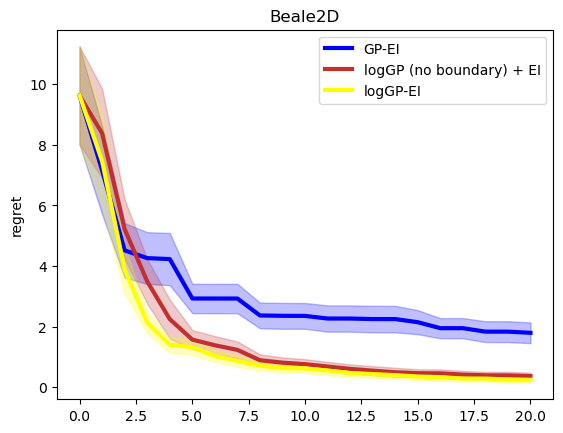

In [11]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Beale2D_logBO_EI'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Beale2D_logBO_no_boundary_EI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Beale2D_BO_EI'), delimiter=',')

N = 20

fstar = 0.

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = np.array(logBO_no_boundary_HanyangEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP (no boundary) + EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')


plt.ylabel('regret')
plt.title('Beale2D')
plt.legend()

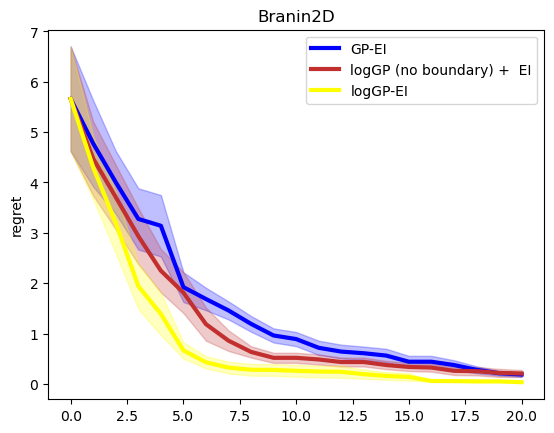

In [12]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Branin2D_logBO_EI'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Branin2D_logBO_no_boundary_EI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Branin2D_BO_EI'), delimiter=',')

fstar = 0.397887

total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = np.array(logBO_no_boundary_HanyangEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP (no boundary) +  EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')


plt.ylabel('regret')
plt.title('Branin2D')
plt.legend()

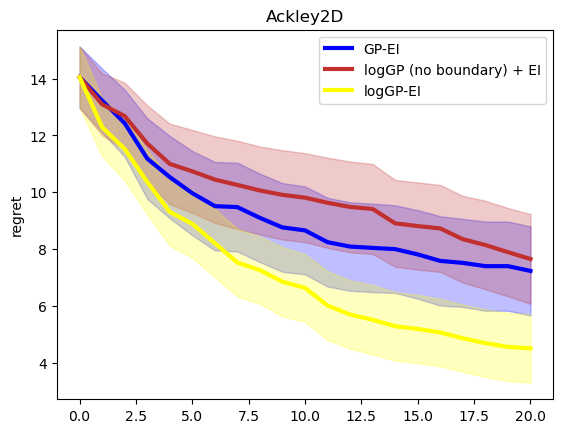

In [9]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Ackley2D_logBO_EI'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Ackley2D_logBO_no_boundary_EI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Ackley2D_BO_EI'), delimiter=',')

fstar = 0.
N = 20


total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = np.array(logBO_no_boundary_HanyangEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP (no boundary) + EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Ackley2D')
plt.legend()

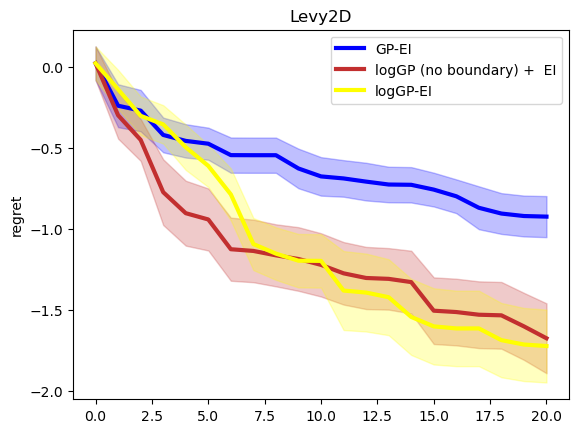

In [10]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Levy2D_logBO_EI'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Levy2D_logBO_no_boundary_EI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Levy2D_BO_EI'), delimiter=',')

fstar = 0.
N = 20
total_record = np.log10(np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = np.log10(np.array(logBO_no_boundary_HanyangEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP (no boundary) +  EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.log10(np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Levy2D')
plt.legend()

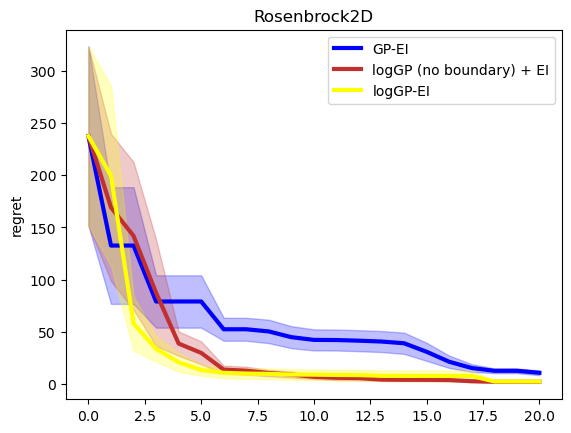

In [10]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Rosenbrock2D_logBO_EI'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp3/Rosenbrock2D_logBO_no_boundary_EI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Rosenbrock2D_BO_EI'), delimiter=',')

fstar = 0.
N = 20


total_record = np.array(BO_EI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = np.array(logBO_no_boundary_HanyangEI)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP (no boundary) + EI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = np.array(Warped_BO_TEI2)-fstar
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-EI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Rosenbrock2D')
plt.legend()

# logGP + standard EI

In [83]:
fun = Branin(negate=False)
dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)
 
n_init = 4*dim
iter_num = 10*dim
N = 20

fstar = 0.397887
fun = Trans_function(fun,fstar,min=True)

In [84]:
Warped_BO_standardEI = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]

    for i in range(iter_num):
            
            #print(i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            # train the GP
            res = optimise_warp(train_X, train_Y)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            # print('lengthscale is: ', lengthscale)
            # print('variance is: ',variance)
            # print('c is: ',c)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            minimal = np.min(warp_Y_standard)
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            #print(best_record[-1])
            
    best_record = np.array(best_record)+fstar         
    Warped_BO_standardEI.append(best_record)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [85]:
np.savetxt('exp_no_boundary/'+'Branin2D'+'_logBO_standardEI', Warped_BO_standardEI, delimiter=',')

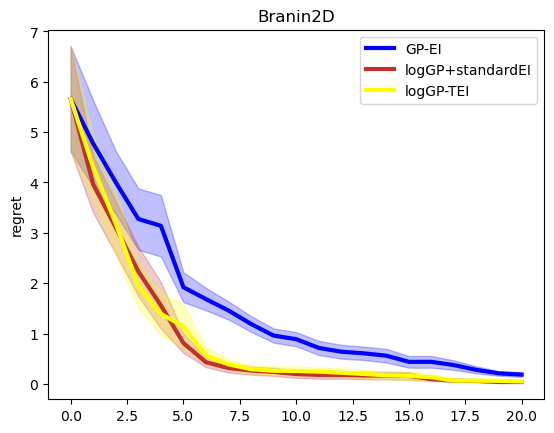

In [87]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Branin2D_logBO_TEI2'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp_no_boundary/Branin2D_logBO_standardEI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Branin2D_BO_EI'), delimiter=',')

fstar = 0.397887

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = (np.array(logBO_no_boundary_HanyangEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+standardEI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-TEI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Branin2D')
plt.legend()

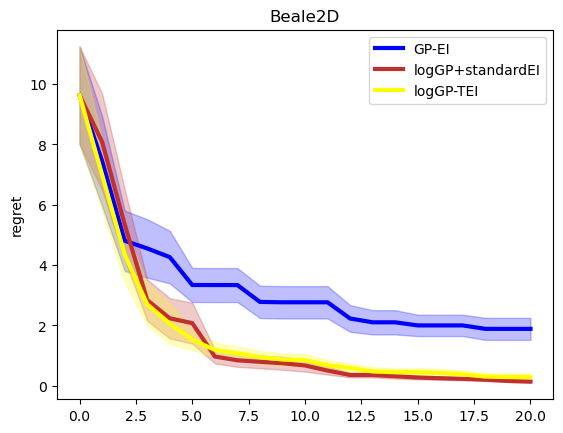

In [82]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Beale2D_logBO_TEI2'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp_no_boundary/Beale2D_logBO_standardEI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Beale2D_BO_EI'), delimiter=',')

fstar = 0.

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = (np.array(logBO_no_boundary_HanyangEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+standardEI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-TEI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Beale2D')
plt.legend()

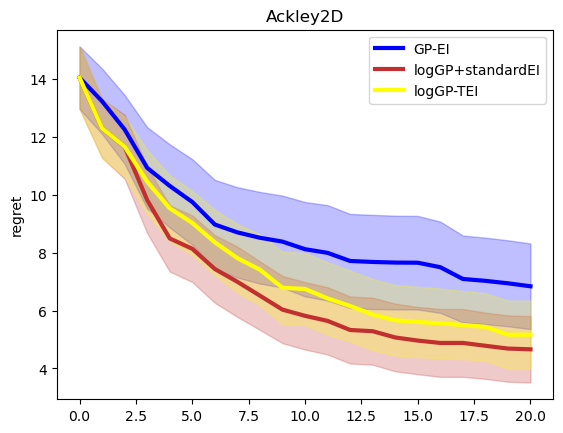

In [78]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Ackley2D_logBO_TEI2'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp_no_boundary/Ackley2D_logBO_standardEI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Ackley2D_BO_EI'), delimiter=',')

fstar = 0.

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = (np.array(logBO_no_boundary_HanyangEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+standardEI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-TEI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Ackley2D')
plt.legend()

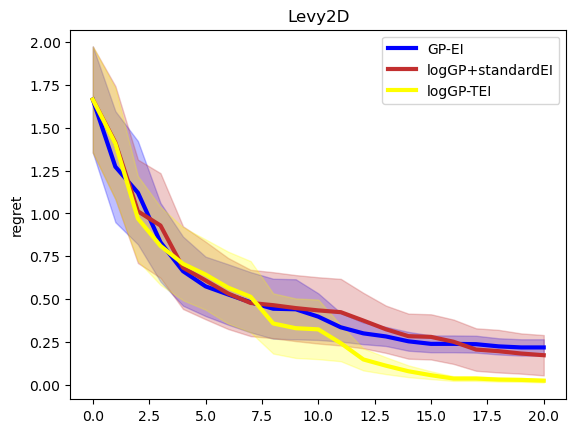

In [74]:
Warped_BO_TEI2 = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Levy2D_logBO_TEI2'), delimiter=',')
logBO_no_boundary_HanyangEI = np.genfromtxt(os.path.join(os.getcwd(),'exp_no_boundary/Levy2D_logBO_standardEI'), delimiter=',')
BO_EI = np.genfromtxt(os.path.join(os.getcwd(),'exp_res/Levy2D_BO_EI'), delimiter=',')

fstar = 0.

total_record = (np.array(BO_EI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP-EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')


total_record = (np.array(logBO_no_boundary_HanyangEI)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP+standardEI',color='#c22f2f')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='#c22f2f')

total_record = (np.array(Warped_BO_TEI2)-fstar)
mean = np.mean(total_record,axis=0)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logGP-TEI',color='yellow')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='yellow')

plt.ylabel('regret')
plt.title('Levy2D')
plt.legend()

# Check the distance of so-far best

In [8]:
logBO_no_boundary_HanyangEI = []
distance_holder = []

for exp in range(N):
    
    print(exp)

    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]
    distance_record = []

    for i in range(iter_num):
            
            #print(i)
            
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            fstar_standard = (fstar - Y_BO.mean()) / Y_BO.std()
            fstar_standard = fstar_standard.item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            standard_best_record = [np.min(train_Y)]
            
            best_x = train_X[np.argmin(train_Y)]
            
            
            # train the GP
            res = optimise_warp_no_boundary(train_X, train_Y,-fstar_standard+1.5)
            lengthscale = np.sqrt(res[0])
            variance = res[1]
            c = res[2]
            
            print('lengthscale is: ', lengthscale)
            print('variance is: ',variance)
            print('c is: ',c)
            print('check:',-np.min(train_Y)+10**(-5),-np.min(train_Y)-fstar_standard+1.5)
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
              
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  #np.sqrt(res[0])
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(10**(-5))
            
            standard_next_X = Warped_EI_acquisition_opt(model=m,bounds=standard_bounds,f_best=standard_best_record[-1],c=c,f_mean=mean_warp_Y)
            
            distance = np.linalg.norm(standard_next_X-best_x)
            distance_record.append(distance)
            
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    logBO_no_boundary_HanyangEI.append(best_record)
    distance_holder.append(distance_record)

0
lengthscale is:  0.21766330336947018
variance is:  0.01
c is:  10.739315283525325
check: 2.8949459657149585 52.027511268392324
19.79565601261103
lengthscale is:  0.25483461835827637
variance is:  0.01
c is:  9.45243695823927
check: 2.5092605454801613 46.65376528939486
19.79565601261103
lengthscale is:  0.22234303065035751
variance is:  0.01
c is:  8.95482326259617
check: 2.3145323077966067 44.20642406926291
19.79565601261103
lengthscale is:  0.12210639201071534
variance is:  0.01
c is:  8.762469604997628
check: 2.19726343758505 42.91132262249962
19.155228636567482
lengthscale is:  0.060358682300945425
variance is:  0.01
c is:  9.459936119823755
check: 2.853963734384938 38.29178408761248
19.155228636567482
lengthscale is:  0.06028424770236834
variance is:  0.01
c is:  9.495696815185312
check: 2.803094329376841 38.02289335504316
19.155228636567482
lengthscale is:  0.06028572466708747
variance is:  0.01
c is:  9.54880665951151
check: 2.7265908731405144 37.470484347047325
19.155228636567

In [9]:
np.savetxt('training_check/Ackley7D_logBO_no_boundary_EI_distance', distance_holder, delimiter=',')